In [ ]:
!python -m pip install \
umap \
matplotlib \
scikit-learn \
seaborn \
umap-learn \
sentence-transformers

In [1]:
import os
import glob
import numpy as np
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import time
%matplotlib inline

In [2]:
DATA_PATH = os.path.join("data", "livedoor", "text")

In [3]:
def extract_contents(file_name):
    with open(file_name) as file:
        lines = file.readlines()
    title = lines[2].strip()
    contents = lines[3:]
    contents = [sentence.strip() for sentence in contents] 
    contents = list(filter(lambda line: line != '', contents))
    contents = [l.translate(str.maketrans({'\n': '', '\t': '', '\r': '', '\u3000': ''}))
        for l in contents]
    contents = ["".join(contents)]
    return title, contents

In [4]:
file_name = "data/livedoor/text/dokujo-tsushin/dokujo-tsushin-4778030.txt"
extract_contents(file_name)

('友人代表のスピーチ、独女はどうこなしている？',
 ['もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」さてそんなとき、独女はどう対応したらいいか？最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳）「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」サプライズスピーチのメリットとしては、準備していない状態なので、フランクな本音をしゃべってもらえるという楽しさがあるようだ。しかしそれも上手に対応できる人ならいいが、苦手な人の場合だと「フランク」ではなく「しどろもどろ」になる危険性大。ちなみにプロの司会者の場合、本当のサプライズではなく式の最中に「のちほどサプライズスピーチとしてご指名さ

In [5]:
data_list = []
categories = []

for cat in os.listdir(DATA_PATH):
    if not os.path.isdir(os.path.join(DATA_PATH, cat)):
        continue
    print(cat)
    categories.append(cat)
    files = glob.glob(os.path.join(DATA_PATH, cat, "*.txt"))
    for f in files:
        title, contents = extract_contents(f)
        if title.startswith("原著作者のクレジットを表示し、"):
            continue
        data_list += [[cat, title, cnt] for cnt in contents]

movie-enter
it-life-hack
kaden-channel
topic-news
livedoor-homme
peachy
sports-watch
dokujo-tsushin
smax


In [6]:
len(data_list)

7367

In [7]:
data_list[2]

['movie-enter',
 '『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席',
 '3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』。早くもアカデミー賞最有力候補として大きな注目を集めている同作のロンドン ロイヤル・プレミアが、現地時間8日（日本時間9日未明）に行われた。本プレミアは、英国王室ウィリアム王子とハリー王子が運営する慈善団体のチャリティイベントとして開催され、会場には昨年4月にロイヤル・ウェディングを挙げたウィリアム王子とキャサリン妃も出席。結婚後、初の映画プレミア公式出席に会場のレスタースクエアは、ファンの大歓声に包まれた。『戦火の馬』は、第一次大戦を舞台に、悲劇に見舞われながらも希望を信じて生き抜く人間たちの姿を、ジョーイという一頭の美しい馬との出会いと別れを通して描く感動作。原作は、100作を超える名作を世に送り出し英国王室から叙勲もされているマイケル・モーパーゴが、1982年に発表した同名小説。25年後の2007年、舞台劇としてロンドンのロイヤル・シアターにて上演されるや「希望」と「絆」をテーマにした感動の物語が人気を博し数々の演劇賞に輝いた。評判を聞きつけたエリザベス女王もエジンバラ公と共に何度かお忍びで劇場を訪れている。女王をも感動させたこの物語が、誕生から30年もの年月を経てスピルバーグ監督の手によって映画として生まれ変わった。今年のオスカーレースでトップをひた走る話題作とあって、欧州メディアを中心に約300人ものマスコミが集まり、沿道は500名を超えるファンで埋め尽くされた。午後5時頃、スピルバーグ監督、ジェレミー・アーヴァイン、トム・ヒドルストン、ベネディクト・カンバーバッチそして馬のジョーイらがレッドカーペットに登場。続いてウィリアム王子とキャサリン妃がレスタースクエアに到着。折からの小雨を避けるように、王子がキャサリン妃に傘をさしかけ、一つの傘でゆっくりとレッドカーペットを歩いた。明けて9日が30歳の誕生日を迎えるキャサリン妃はアリス・バイ・テンパリーの黒のドレスで登場。2人は会場のオデオン劇場（1600名収容）ではスピルバーグ監督らスタッフ＆キャストと丁寧に言葉を交わしていた。30年もの間、文学、演劇、映画と、時と共に形を変え人々から愛されてきた「希望」と「絆

In [8]:
data_frame = pd.DataFrame(data_list, columns=["category", "title", "sentence"])

In [9]:
data_frame.head()

,category,title,sentence
0,movie-enter,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...
1,movie-enter,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」2月28日、映画『おかえり、はやぶさ』（3月10...
2,movie-enter,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...
3,movie-enter,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...
4,movie-enter,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...


In [10]:
data = data_frame["sentence"]

In [11]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [12]:
embeddings = model.encode(data, show_progress_bar=True)
embeddings.shape

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

(7367, 512)

In [13]:
reducer = umap.UMAP()

In [14]:
stime = time.time()
mapped_data = reducer.fit_transform(embeddings)
print(time.time() - stime)
mapped_data.shape

9.738755941390991


(7367, 2)

In [15]:
data_frame["umap_x"] = mapped_data[:, 0]
data_frame["umap_y"] = mapped_data[:, 1]

In [16]:
data_frame.head()

,category,title,sentence,umap_x,umap_y
0,movie-enter,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...,-3.399698,7.059068
1,movie-enter,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」2月28日、映画『おかえり、はやぶさ』（3月10...,-2.072591,7.324537
2,movie-enter,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...,-3.540777,7.244929
3,movie-enter,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...,-2.585827,7.543404
4,movie-enter,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...,-2.728610,7.397020


In [17]:
cat_data = data_frame["category"]
numbers = range(len(categories))
color_dict = {cat: num for cat, num in zip(categories, numbers)}

movie-enter 870
it-life-hack 870
kaden-channel 864
topic-news 770
livedoor-homme 511
peachy 842
sports-watch 900
dokujo-tsushin 870
smax 870


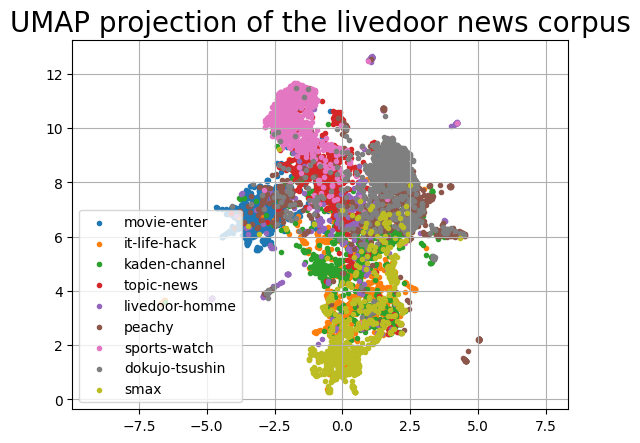

In [18]:
fig, ax = plt.subplots()

for cat in categories:
    color = sns.color_palette()[color_dict[cat]]
    df = data_frame[data_frame["category"] == cat]
    x = df["umap_x"].values
    y = df["umap_y"].values
    n = len(x)
    scatter = ax.scatter(
        x, y,
        color=color,
        label=cat,
        marker="."
    )
    print(f"{cat} {n}")

ax.legend()
ax.grid(True)
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the livedoor news corpus", fontsize=20)
plt.show()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

Text(0.5, 0.98, 'UMAP projection of the livedoor news corpus')

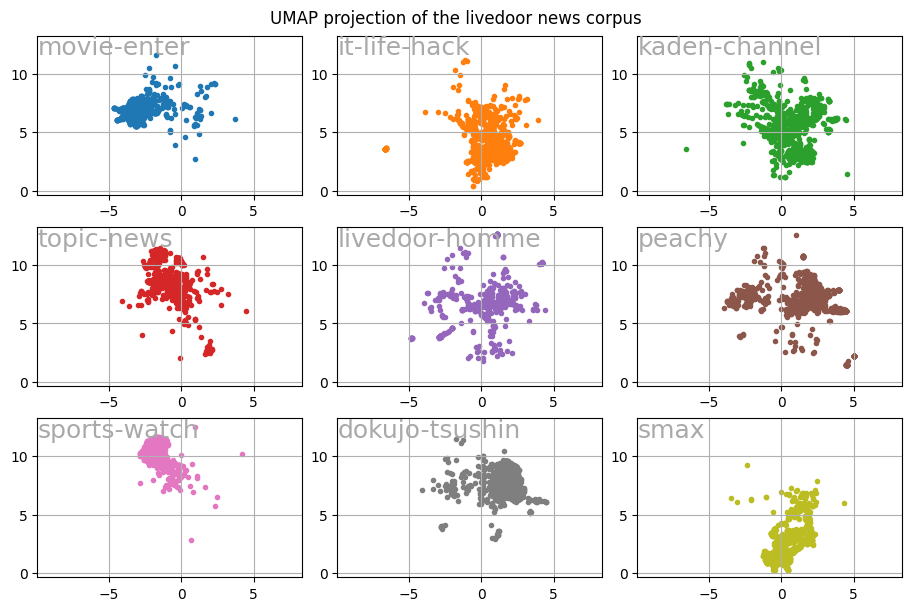

In [19]:
num_figs = len(categories)
num_cols = 3
num_rows = (num_figs + num_cols - 1) // num_cols

fig, axs = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(9, 6),
                        layout="constrained")

i = 0
for row in range(num_rows):
    for col in range(num_cols):
        cat = categories[i]
        color = sns.color_palette()[color_dict[cat]]
        df = data_frame[data_frame["category"] == cat]
        x = df["umap_x"].values
        y = df["umap_y"].values
        ax = axs[row, col]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.scatter(
            x, y,
            color=color,
            label=cat,
            marker="."
        )
        ax.annotate(
            f"{cat}", (xlim[0], ylim[1]),
            transform=axs[row, col].transAxes,
            ha='left', va='top', fontsize=18,
            color='darkgrey'
        )
        i += 1
fig.suptitle("UMAP projection of the livedoor news corpus")

In [23]:
data_frame[(data_frame["category"] == "smax") & (data_frame["umap_y"] > 8.0)]

,category,title,sentence,umap_x,umap_y
6810,smax,ソフトバンク、福岡県限定のキャンペーン「燃えろ！VV終盤戦キャンペーン」を9月1日から開始,福岡で契約するとオリジナルグッズがもらえるらしいぞ！ソフトバンクモバイルは8月30日、プロ野...,-2.352613,9.241835


In [25]:
data_frame[(data_frame["category"] == "sports-watch") & (data_frame["umap_y"] < 5.0)]

,category,title,sentence,umap_x,umap_y
5397,sports-watch,【Sports Watch】ビーチバレーで写メ解禁も「喜ぶファンなんていない」,今月1日、日本ビーチバレー連盟は、公式サイト上で「携帯電話による写真撮影解禁」とし、「これま...,0.673561,2.830384
